In [14]:
# testing the subtract model
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [15]:
# generate dummy data


# generate a data that is pep one hot encoding with N=14, d=21. mhc_emb with N= 312 and d =1152. a contact map that is a soft weights over 312 mhc positions

# Create dummy data
num_samples = 1000

# Peptide One-Hot Encoding (N=14, d=21)
pep_len = 14
pep_alphabet_size = 21
pep_indices = np.random.randint(0, pep_alphabet_size, size=(num_samples, pep_len))
pep_OHE = tf.one_hot(pep_indices, depth=pep_alphabet_size, dtype=tf.float32)

# MHC Embedding (N=312, d=1152)
mhc_len = 312
mhc_embedding_dim = 1152
mhc_emb = tf.random.normal(shape=(num_samples, mhc_len, mhc_embedding_dim))

# Contact Map (soft weights over 312 MHC positions for each of the 14 peptide positions)
contact_map_logits = tf.random.normal(shape=(num_samples, pep_len, mhc_len))
contact_map = tf.nn.softmax(contact_map_logits, axis=-1)

# Define pad and mask tokens
pad_token = -2.0
mask_token = -1.0

# Generate peptide mask
# Let's assume a variable number of padded/masked tokens per sample
pep_mask = np.ones((num_samples, pep_len), dtype=np.float32)
for i in range(num_samples):
    # Add 0 to 3 padded tokens at the end
    num_padded = np.random.randint(0, 4)
    if num_padded > 0:
        pep_mask[i, -num_padded:] = pad_token
    # Add 0 to 2 masked tokens at random positions that are not padded
    num_masked = np.random.randint(0, 3)
    valid_indices = np.where(pep_mask[i] == 1.0)[0]
    if num_masked > 0 and len(valid_indices) >= num_masked:
        mask_indices = np.random.choice(valid_indices, num_masked, replace=False)
        pep_mask[i, mask_indices] = mask_token

pep_mask = tf.constant(pep_mask, dtype=tf.float32)

# Generate MHC mask (similar logic)
mhc_mask = np.ones((num_samples, mhc_len), dtype=np.float32)
for i in range(num_samples):
    # Add 0 to 10 padded tokens
    num_padded = np.random.randint(0, 11)
    if num_padded > 0:
        mhc_mask[i, -num_padded:] = pad_token
mhc_mask = tf.constant(mhc_mask, dtype=tf.float32)


# Zero out masked positions in the data
# Create boolean masks where True means the position is valid (not padded or masked)
pep_bool_mask = tf.cast(pep_mask > 0, dtype=tf.float32)
mhc_bool_mask = tf.cast(mhc_mask > 0, dtype=tf.float32)

# Apply masks to zero out data. Unsqueeze to allow broadcasting.
pep_OHE = pep_OHE * pep_bool_mask[:, :, tf.newaxis]
mhc_emb = mhc_emb * mhc_bool_mask[:, :, tf.newaxis]



In [16]:
# model

class SubtractLayer(keras.layers.Layer):
    """
    Custom layer to subtract a tensor from another tensor.
    Tensor1: (B, P, D) -> (B, P*D) -> (B, M, P*D)
    Tensor2: (B, M, D) -> (B, M, P*D)
    Output: = Tensor2 - Tensor1
    """
    def __init__(self, mask_token=-1., pad_token=-2., **kwargs):
        """Initialize the layer."""
        super(SubtractLayer, self).__init__(**kwargs)
        self.mask_token = mask_token
        self.pad_token = pad_token

    def call(self, peptide, pep_mask, mhc, mhc_mask):
        B = tf.shape(peptide)[0]
        P = tf.shape(peptide)[1]
        D = tf.shape(peptide)[2]
        M = tf.shape(mhc)[1]
        P_D = P * D

        pep_mask = tf.cast(pep_mask, tf.float32)
        mhc_mask = tf.cast(mhc_mask, tf.float32)

        pep_mask = tf.where(pep_mask == self.pad_token, x=0., y=1.)  # (B,P)
        mhc_mask = tf.where(mhc_mask == self.pad_token, x=0., y=1.)

        # peptide  (B,P,D) -> (B,P*D) -> (B,M,P*D)
        peptide_flat = tf.reshape(peptide, (B, P_D))
        peptide_exp = tf.repeat(peptide_flat[:, tf.newaxis, :], repeats=M, axis=1)
        # mhc       (B,M,D) -> tile last axis P times -> (B,M,P*D)
        mhc_exp = tf.tile(mhc, [1, 1, P])
        result = mhc_exp - peptide_exp  # (B,M,P*D)
        # peptide mask  (B,P) -> (B,P,D) -> flatten -> (B,P*D) -> (B,M,P*D)
        pep_mask_PD = tf.tile(pep_mask[:, :, tf.newaxis], [1, 1, D])  # (B,P,D)
        pep_mask_PD = tf.reshape(pep_mask_PD, (B, P_D))  # (B,P*D)
        pep_mask_PD = tf.repeat(pep_mask_PD[:, tf.newaxis, :], repeats=M, axis=1)  # (B,M,P*D)
        # mhc mask      (B,M) -> (B,M,1) -> repeat P*D along last axis
        mhc_mask_PD = tf.repeat(mhc_mask[:, :, tf.newaxis], repeats=P_D, axis=2)  # (B,M,P*D)
        combined_mask = tf.logical_and(tf.cast(pep_mask_PD, tf.bool), tf.cast(mhc_mask_PD, tf.bool))
        masked_result = tf.where(combined_mask, result, tf.zeros_like(result))
        return masked_result

Peptide OHE shape: (1000, 14, 21)
Peptide mask shape: (1000, 14)
Compatible MHC embedding shape: (1000, 312, 21)
MHC mask shape: (1000, 312)
Output tensor shape: (1000, 312, 294)


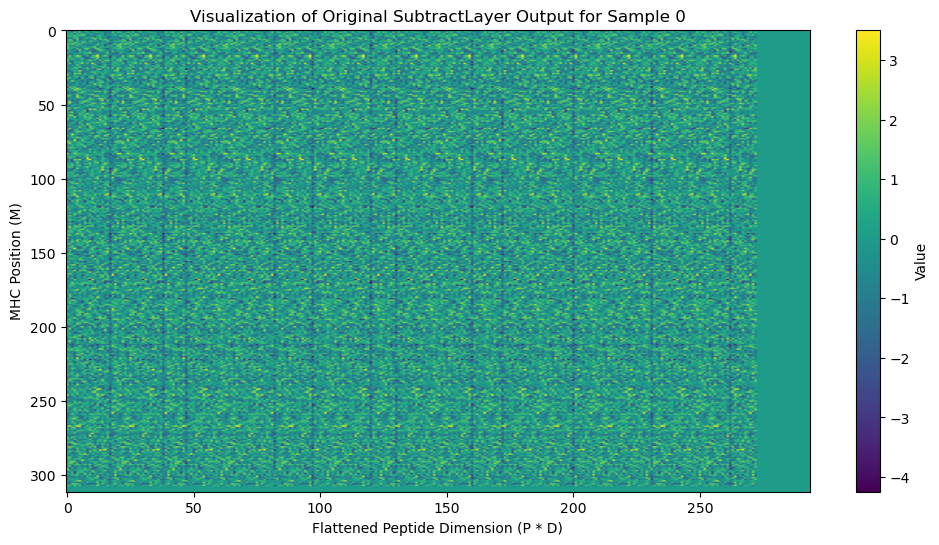

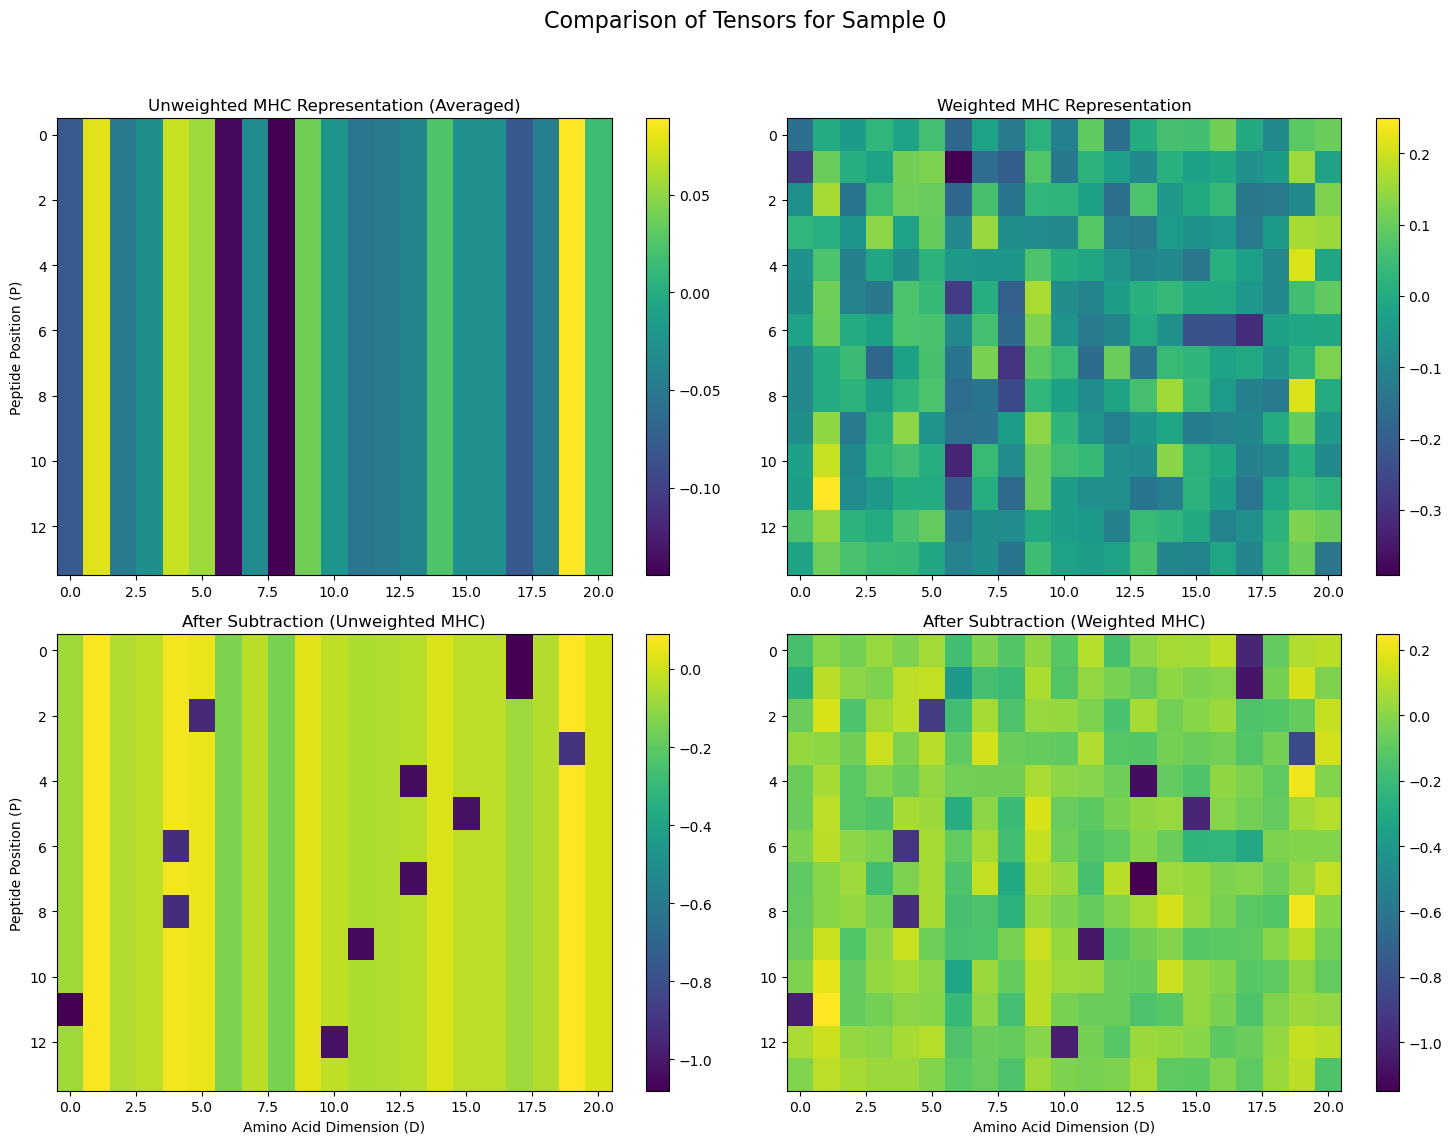

In [17]:
from tensorflow import keras

# The SubtractLayer expects peptide and mhc tensors to have the same last dimension.
# Let's create a dummy mhc tensor with the correct shape for the test.
# The last dimension should match pep_OHE's last dimension (pep_alphabet_size = 21).
mhc_compatible_emb = tf.random.normal(shape=(num_samples, mhc_len, pep_alphabet_size))

# Instantiate the layer
subtract_layer = SubtractLayer()

# Call the layer with the dummy data
output_tensor = subtract_layer(pep_OHE, pep_mask, mhc_compatible_emb, mhc_mask)

# Print the shapes to verify the output
print("Peptide OHE shape:", pep_OHE.shape)
print("Peptide mask shape:", pep_mask.shape)
print("Compatible MHC embedding shape:", mhc_compatible_emb.shape)
print("MHC mask shape:", mhc_mask.shape)
print("Output tensor shape:", output_tensor.shape)

# Visualize a small part of the output for one sample
import matplotlib.pyplot as plt

# Let's check the first sample
sample_index = 0
output_sample = output_tensor[sample_index].numpy()

# Reshape output tensor to (M, P, D) for easier visualization and weighting
B, M, PD = output_tensor.shape
P = pep_len
D = pep_alphabet_size
output_tensor_reshaped = tf.reshape(output_tensor, (B, M, P, D))

# Transpose contact map to be (B, M, P)
contact_map_transposed = tf.transpose(contact_map, perm=[0, 2, 1])

# Apply contact map weights. Add a new axis to contact map for broadcasting.
weighted_output = output_tensor_reshaped * contact_map_transposed[:, :, :, tf.newaxis]

# Sum over the M dimension to get a weighted representation for each peptide position
weighted_peptide_repr = tf.reduce_sum(weighted_output, axis=1) # (B, P, D)


# New approach: Weight MHC embeddings before subtraction
# contact_map is (B, P, M), mhc_compatible_emb is (B, M, D)
# We want to get (B, P, D)
# Transpose mhc and contact map for batch matrix multiplication
mhc_transposed = tf.transpose(mhc_compatible_emb, perm=[0, 2, 1]) # (B, D, M)
contact_map_for_matmul = contact_map # (B, P, M)

# Batch matrix multiplication
# The result for each item in the batch will be (P, M) x (M, D) -> (P, D)
weighted_mhc_repr = tf.matmul(contact_map_for_matmul, mhc_compatible_emb) # (B, P, D)

# Now we need a new subtract layer, or a modified one.
# Let's create a new output based on this weighted_mhc_repr
# The original peptide is (B, P, D). The new mhc is (B, P, D).
# We can just subtract them.
new_weighted_output = weighted_mhc_repr - pep_OHE


# Create an unweighted MHC representation for comparison by averaging over the M dimension
unweighted_mhc_for_subtraction = tf.tile(tf.reduce_mean(mhc_compatible_emb, axis=1, keepdims=True), [1, P, 1])
unweighted_subtraction_output = unweighted_mhc_for_subtraction - pep_OHE


plt.figure(figsize=(12, 6))
plt.title(f"Visualization of Original SubtractLayer Output for Sample {sample_index}")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel("Flattened Peptide Dimension (P * D)")
plt.ylabel("MHC Position (M)")
plt.colorbar(label="Value")
plt.show()

# Visualize the comparisons in a 2x2 grid
unweighted_mhc_sample = unweighted_mhc_for_subtraction[sample_index].numpy()
weighted_mhc_sample = weighted_mhc_repr[sample_index].numpy()
unweighted_sub_sample = unweighted_subtraction_output[sample_index].numpy()
weighted_sub_sample = new_weighted_output[sample_index].numpy()


fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f"Comparison of Tensors for Sample {sample_index}", fontsize=16)

# Top-left: Unweighted MHC
im = axes[0, 0].imshow(unweighted_mhc_sample, aspect='auto', cmap='viridis')
axes[0, 0].set_title("Unweighted MHC Representation (Averaged)")
axes[0, 0].set_ylabel("Peptide Position (P)")
fig.colorbar(im, ax=axes[0, 0])

# Top-right: Weighted MHC
im = axes[0, 1].imshow(weighted_mhc_sample, aspect='auto', cmap='viridis')
axes[0, 1].set_title("Weighted MHC Representation")
fig.colorbar(im, ax=axes[0, 1])

# Bottom-left: Unweighted Subtraction
im = axes[1, 0].imshow(unweighted_sub_sample, aspect='auto', cmap='viridis')
axes[1, 0].set_title("After Subtraction (Unweighted MHC)")
axes[1, 0].set_xlabel("Amino Acid Dimension (D)")
axes[1, 0].set_ylabel("Peptide Position (P)")
fig.colorbar(im, ax=axes[1, 0])

# Bottom-right: Weighted Subtraction
im = axes[1, 1].imshow(weighted_sub_sample, aspect='auto', cmap='viridis')
axes[1, 1].set_title("After Subtraction (Weighted MHC)")
axes[1, 1].set_xlabel("Amino Acid Dimension (D)")
fig.colorbar(im, ax=axes[1, 1])


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [18]:
#
